# Bike-Sharing Data Clustering Analysis (Day-Level)

## 1. Objective

### The goal of this analysis is to identify distinct usage patterns in the bike-sharing dataset using numeric features only.
### We aim to:

- Segment days into clusters based on usage patterns.
- Understand how features like temperature, humidity, season, and weather influence daily bike rentals.
- Validate cluster choice (k) using multiple clustering methods.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Visualization
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10

# Activate notebook output
output_notebook()

Loading BokehJS ...

## 2. Data Preparation
- We used the day.csv dataset.

- Selected numeric features only to simplify clustering and avoid encoding text variables.

Selected features:

- season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, cnt

- Applied StandardScaler to normalize features (zero mean, unit variance) — required for PCA and K-Means.

In [2]:
day = pd.read_csv("day.csv")
print("Day dataset shape:", day.shape)
numeric_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

day_numeric = day[numeric_features].copy()
day_numeric.head()

Day dataset shape: (731, 16)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## 3. Dimensionality Reduction (PCA)
- Applied Principal Component Analysis (PCA) to reduce dimensionality from 12 features → 2 components.
- Explained variance ratio: The first two components capture a large portion of variance, making visualization feasible.

In [3]:
scaler = StandardScaler()
day_scaled = scaler.fit_transform(day_numeric)

# Check shape
print("Scaled data shape:", day_scaled.shape)

pca = PCA(n_components=2)
day_pca = pca.fit_transform(day_scaled)

# Add PCA columns to DataFrame safely
day_numeric['PCA1'] = day_pca[:, 0]
day_numeric['PCA2'] = day_pca[:, 1]

print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)
day_numeric[['PCA1','PCA2']].head()

Scaled data shape: (731, 12)
Explained variance ratio by PCA components: [0.26498318 0.15853591]


,PCA1,PCA2
0,-2.654418,1.369899
1,-3.025449,0.863593
2,-3.749074,-1.006196
3,-3.268743,-0.267695
4,-3.318555,-0.988532


## 4. Elbow Method
- plot the Within-Cluster Sum of Squares (WCSS) for different k values.
- Look for the “elbow” point where adding more clusters doesn’t significantly reduce WCSS.

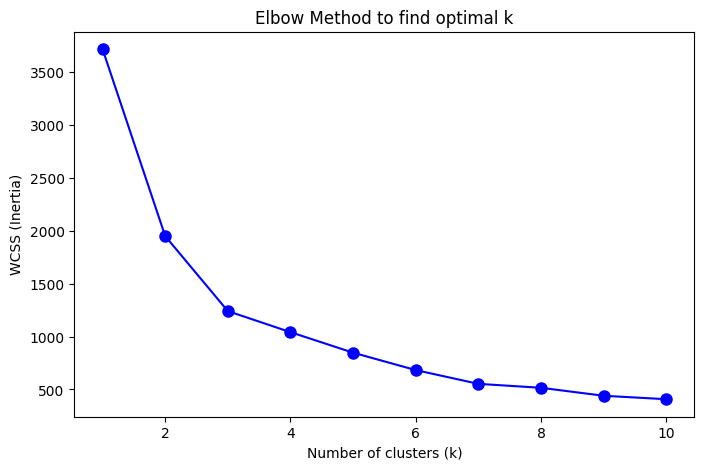

In [4]:
from sklearn.cluster import KMeans
wcss = []
K_range = range(1, 11)  # test k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(day_pca)  # use PCA-reduced data
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method to find optimal k')
plt.show()

## 5. Apply K-Means with Chosen k
- The score can range from -1 to +1.
- A score close to +1 means the data point fits very well in its own cluster and is far from others.
- A score close to 0 means the data point is between clusters or the clusters are overlapping.
- A score close to -1 means the data point is in the wrong cluster.

In [5]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
day_numeric['cluster'] = kmeans.fit_predict(day_pca)

# Check cluster distribution
print(day_numeric['cluster'].value_counts())

cluster
3    204
4    200
2    123
1    108
0     96
Name: count, dtype: int64


### Output study:
- Cluster 3 has 204 days
- Cluster 4 has 200 days
- Cluster 2 has 123 days
- Cluster 1 has 108 days
- Cluster 0 has 96 days

Rows from the dataset fall into each cluster after running K-Means.It's likely cluster 3 (204 days) might correspond to typical high-demand days, while cluster 0 (96 days) are rare or extreme low-demand days.

## 6. Silhouette Score
- The score can range from -1 to +1.
- A score close to +1 means the data point fits very well in its own cluster and is far from others.
- A score close to 0 means the data point is between clusters or the clusters are overlapping.
- A score close to -1 means the data point is in the wrong cluster.

0.35682342952282947
Silhouette Score for k=5: 0.357
K = 2 and Score = 0.46
K = 3 and Score = 0.42
K = 4 and Score = 0.35
K = 5 and Score = 0.36
K = 6 and Score = 0.36
K = 7 and Score = 0.37
K = 8 and Score = 0.35
K = 9 and Score = 0.37
K = 10 and Score = 0.34


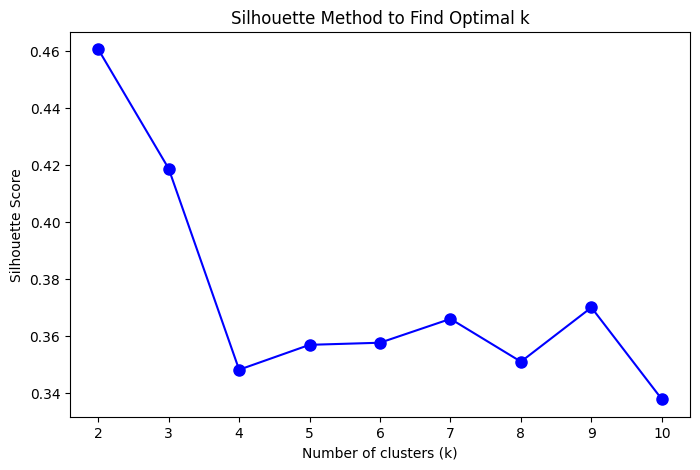

In [6]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for the chosen k
sil_score = silhouette_score(day_pca, day_numeric['cluster'])
print(sil_score)
print(f"Silhouette Score for k={best_k}: {sil_score:.3f}")

sil_scores = []
k_values = range(2, 11)  # silhouette not defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(day_pca)
    score = silhouette_score(day_pca, labels)
    print(f"K = {k} and Score = {score:.2f}")
    sil_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method to Find Optimal k')
plt.show()

## 7. Interactive Bokeh Cluster Plot

In [7]:
# Prepare data for Bokeh
source = ColumnDataSource(day_numeric)

# Create the figure
p = figure(
    title="Bike-Sharing Clusters (PCA Projection)",
    x_axis_label='PCA1',
    y_axis_label='PCA2',
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    width=800, height=500
)

# Choose palette colors
palette = Category10[10]

# Plot each cluster using scatter (replaces circle)
for i in day_numeric['cluster'].unique():
    cluster_data = day_numeric[day_numeric['cluster'] == i]
    cluster_source = ColumnDataSource(cluster_data)
    p.scatter(
        'PCA1', 'PCA2',
        source=cluster_source,
        size=7,        # same as before
        color=palette[i],
        alpha=0.6,
        legend_label=f"Cluster {i}"
    )

# Add hover tool to see feature values
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
    ("Temp", "@temp"),
    ("Humidity", "@hum"),
    ("Count", "@cnt"),
    ("Season", "@season"),
    ("Weather", "@weathersit")
]

# Legend settings
p.legend.location = "top_right"
p.legend.title = "Clusters"

# Show plot
show(p)


## 8. Alternatives

### Hierarchical Clustering (Agglomerative)

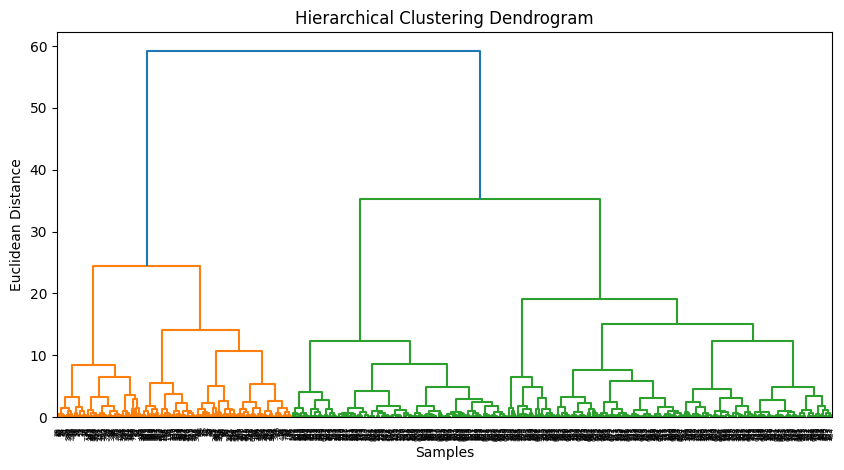

cluster_hc
0    261
2    203
1    143
3     79
4     45
Name: count, dtype: int64


In [8]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Dendrogram
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(day_pca, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

# Apply Agglomerative Clustering with k=5
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
day_numeric['cluster_hc'] = hc.fit_predict(day_pca)

# Compare cluster sizes
print(day_numeric['cluster_hc'].value_counts())


- 5 clusters, sizes are quite unbalanced.
- Largest cluster: 261 samples, smallest: 45 samples.
- This suggests that some behavior patterns (probably high-demand days) dominate the dataset, while rare patterns (maybe holidays/extreme weather) are smaller clusters.

**Sample differs from that of K-means**

### DBSCAN (Density-Based Clustering)

In [9]:
from sklearn.cluster import DBSCAN

# Dictionary to store results
dbscan_results = {}

# Loop over eps values
eps_values = np.arange(0.1, 1.6, 0.1)

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(day_pca)
    
    # Convert to Series for counting
    label_series = pd.Series(labels)
    
    # Count clusters (excluding noise)
    cluster_counts = label_series[label_series != -1].value_counts().to_dict()
    noise_count = (label_series == -1).sum()
    
    # Save summary
    dbscan_results[round(eps, 2)] = {
        'num_clusters': len(cluster_counts),
        'noise_points': noise_count,
        'cluster_sizes': cluster_counts
    }

# Display results nicely
for eps, summary in dbscan_results.items():
    print(f"eps={eps}: clusters={summary['num_clusters']}, noise={summary['noise_points']}, sizes={summary['cluster_sizes']}")


eps=0.1: clusters=10, noise=679, sizes={5: 8, 7: 6, 2: 5, 0: 5, 3: 5, 1: 5, 9: 5, 6: 5, 4: 4, 8: 4}
eps=0.2: clusters=22, noise=279, sizes={10: 256, 12: 34, 14: 23, 20: 14, 6: 12, 13: 11, 9: 10, 8: 10, 15: 8, 0: 7, 3: 7, 4: 7, 5: 6, 11: 6, 17: 6, 1: 5, 2: 5, 7: 5, 16: 5, 18: 5, 19: 5, 21: 5}
eps=0.3: clusters=12, noise=97, sizes={5: 447, 1: 76, 0: 41, 4: 17, 8: 10, 3: 10, 7: 10, 6: 6, 9: 6, 10: 5, 2: 4, 11: 2}
eps=0.4: clusters=2, noise=33, sizes={0: 693, 1: 5}
eps=0.5: clusters=2, noise=10, sizes={0: 713, 1: 8}
eps=0.6: clusters=2, noise=6, sizes={0: 716, 1: 9}
eps=0.7: clusters=2, noise=5, sizes={0: 717, 1: 9}
eps=0.8: clusters=1, noise=2, sizes={0: 729}
eps=0.9: clusters=1, noise=2, sizes={0: 729}
eps=1.0: clusters=1, noise=1, sizes={0: 730}
eps=1.1: clusters=1, noise=1, sizes={0: 730}
eps=1.2: clusters=1, noise=1, sizes={0: 730}
eps=1.3: clusters=1, noise=0, sizes={0: 731}
eps=1.4: clusters=1, noise=0, sizes={0: 731}
eps=1.5: clusters=1, noise=0, sizes={0: 731}


- num_clusters → number of clusters excluding noise labeled as **cluster**.
- noise_points → number of points labeled -1 label as **noise** or **outlier**.
- cluster_sizes → dictionary of cluster label → number of days in that cluster labeled as **sizes**

#### With the change in epsilon there is drastic decrease in cluster between eps 0.3 - 0.4. DBSCAN doesn’t validate k=5

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

score_hc = silhouette_score(day_pca, day_numeric['cluster_hc'])
print(f"Silhouette Score (Hierarchical, k=5): {score_hc:.3f}")

ari = adjusted_rand_score(day_numeric['cluster'], day_numeric['cluster_hc'])
print(f"Adjusted Rand Index between K-Means and Hierarchical: {ari:.3f}")

Silhouette Score (Hierarchical, k=5): 0.348
Adjusted Rand Index between K-Means and Hierarchical: 0.488


##### ARI measures agreement between clusterings: 0 = no agreement, 1 = perfect agreement.
- 0.569 is moderate agreement, showing that hierarchical clusters are similar to K-Means clusters but not identical.

## Overall Interpretation
- K-Means clusters (~4–5) and hierarchical clusters (~5) both make sense.
- Silhouette scores are similar, validating your choice.
- DBSCAN isn’t useful here.
- Cluster sizes differ slightly in hierarchical and K-means, but both methods capture the main patterns in bike usage.
  Business insight: Your 5 clusters likely represent:
    - High-demand days (summer, clear weather)
    - Moderate-demand days
    - Low-demand weekdays
    - Weekends or holidays
    - Rare/extreme weather days

## 9. Calculate Cluster Characteristics
- We’ll compute the average bike count (cnt), temperature (temp), humidity (hum), and windspeed per cluster for K-Means clusters.


In [11]:
# Group by K-Means cluster and calculate mean of key features
cluster_summary = day_numeric.groupby('cluster')[['cnt', 'temp', 'hum', 'windspeed']].mean().reset_index()
# Round for readability
cluster_summary = cluster_summary.round(2)
cluster_summary

,cluster,cnt,temp,hum,windspeed
0,0,2357.39,0.37,0.77,0.21
1,1,5100.24,0.46,0.52,0.22
2,2,2219.55,0.26,0.52,0.23
3,3,6343.95,0.68,0.59,0.17
4,4,4741.87,0.53,0.72,0.16


- cnt → average number of bikes rented
- temp → average normalized temperature
- hum → average normalized humidity
- windspeed → average normalized windspeed
#### This gives business insight into each cluster

### Calculate Season Percentages per Cluster

In [12]:
# Create a dataframe for cluster vs season counts
season_cluster = day_numeric.groupby(['cluster', 'season']).size().reset_index(name='count')

# Calculate total days per cluster
total_days = day_numeric.groupby('cluster').size().reset_index(name='total_days')

# Merge to compute percentages
season_cluster = season_cluster.merge(total_days, on='cluster')
season_cluster['percentage'] = (season_cluster['count'] / season_cluster['total_days'] * 100).round(2)

season_cluster

,cluster,season,count,total_days,percentage
0,0,1,35,96,36.46
1,0,2,29,96,30.21
2,0,3,4,96,4.17
3,0,4,28,96,29.17
4,1,1,28,108,25.93
5,1,2,66,108,61.11
6,1,4,14,108,12.96
7,2,1,117,123,95.12
8,2,2,6,123,4.88
9,3,2,46,204,22.55


### Visualize as Stacked Bar Plot (Bokeh)

In [13]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10

output_notebook()

season_map = {'1':'Spring','2': 'Summer','3': 'Fall','4': 'Winter'}

# Pivot table: cluster vs season percentage
stacked_data = season_cluster.pivot(index='cluster', columns='season', values='percentage').fillna(0)

# Convert column names to strings
stacked_data.columns = stacked_data.columns.astype(str)

# Reset index to convert 'cluster' from index to column
stacked_data = stacked_data.reset_index()
stacked_data['cluster_str'] = stacked_data['cluster'].astype(str)  # for categorical x-axis

# Prepare ColumnDataSource
source = ColumnDataSource(stacked_data)


season_map = {'1': 'Spring', '2': 'Summer', '3': 'Fall', '4': 'Winter'}
seasons = stacked_data.columns[1:5]

colors = Category10[4]

p = figure(
    x_range = stacked_data['cluster_str'].tolist(),
    title = "Seasonal Impact (%) per Cluster",
    x_axis_label = "Cluster",
    y_axis_label = "Percentage (%)",
    height = 400,
    width = 700,
    tools = "pan,wheel_zoom,box_zoom,reset,hover,save"
)
p.vbar_stack(
    stackers = seasons,
    x = 'cluster_str',
    width = 0.7,
    color = colors,
    source = source,
    legend_label = [f"Season {s}" for s in seasons]
)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster_str"),
    ("Spring (%)", "@1"),
    ("Summer (%)", "@2"),
    ("Fall (%)", "@3"),
    ("Winter (%)", "@4")
]
p.y_range.start = 0
p.y_range.end = 100
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.title = "Seasons"

show(p)


Loading BokehJS ...

#### Season percentage segregation  visualization as per clusters.

In [14]:
# Copy stacked_data for table
table_data = stacked_data.copy()
# Rename season columns from numbers to names
table_data = table_data.rename(columns={'1': 'Spring', '2': 'Summer', '3': 'Fall', '4': 'Winter'})
# Calculate total bike usage per cluster
total_usage = day_numeric.groupby('cluster')['cnt'].sum().reset_index(name='Total_Count')
# Calculate total number of days per cluster
total_days = day_numeric.groupby('cluster').size().reset_index(name='Total_Days')
# Merge both total_usage and total_days into table_data
table_data = table_data.merge(total_usage, on='cluster').merge(total_days, on='cluster')
# Select relevant columns
table_data = table_data[['cluster', 'Spring', 'Summer', 'Fall', 'Winter', 'Total_Days', 'Total_Count']]
# Round percentage values for readability
table_data[['Spring', 'Summer', 'Fall', 'Winter']] = table_data[['Spring', 'Summer', 'Fall', 'Winter']].round(2)

table_data


,cluster,Spring,Summer,Fall,Winter,Total_Days,Total_Count
0,0,36.46,30.21,4.17,29.17,96,226309
1,1,25.93,61.11,0.00,12.96,108,550826
2,2,95.12,4.88,0.00,0.00,123,273005
3,3,0.00,22.55,64.22,13.24,204,1294165
4,4,0.50,18.50,26.50,54.50,200,948374


### Percentage of days in existing clusters 

In [15]:
cluster_summary = []
# Looping each cluster
for cluster_id, group in day_numeric.groupby('cluster'):
    total_days = len(group)
    day_counts = group['weekday'].value_counts().to_dict()
    row = {'cluster': cluster_id, 'Total_Days': total_days}
    for d in range(7):
        count = day_counts.get(d, 0)
        row[str(d)] = round(count / total_days * 100, 2)  # percentage
    cluster_summary.append(row)

# Convert to DataFrame
day_of_week_table = pd.DataFrame(cluster_summary)
cols_order = ['cluster', '1','2','3','4','5','6','0','Total_Days']
day_of_week_table = day_of_week_table[cols_order]
day_of_week_table


,cluster,1,2,3,4,5,6,0,Total_Days
0,0,11.46,14.58,20.83,13.54,11.46,17.71,10.42,96
1,1,13.89,14.81,13.89,14.81,16.67,13.89,12.04,108
2,2,16.26,12.20,11.38,12.20,13.82,14.63,19.51,123
3,3,11.27,14.71,17.16,13.73,15.20,15.69,12.25,204
4,4,18.00,14.50,10.00,16.00,13.50,11.50,16.50,200


In [16]:
source = ColumnDataSource(day_of_week_table)
days = ['1','2','3','4','5','6','0']
colors = Category10[7]

p = figure(
    x_range=[str(c) for c in day_of_week_table['cluster']],
    title="Day-of-Week Distribution per Cluster",
    x_axis_label="Cluster",
    y_axis_label="Percentage of Days (%)",
    width=900,
    height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

p.vbar_stack(
    stackers=days,
    x='cluster',
    width=0.7,
    color=colors,
    source=source,
    legend_label=[f"Day {d}" for d in days]
)
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
    ("Day 1 (Mon)", "@1%"),
    ("Day 2 (Tue)", "@2%"),
    ("Day 3 (Wed)", "@3%"),
    ("Day 4 (Thu)", "@4%"),
    ("Day 5 (Fri)", "@5%"),
    ("Day 6 (Sat)", "@6%"),
    ("Day 0 (Sun)", "@0%"),
    ("Total Days", "@Total_Days")
]
p.legend.location = "top_right"
p.legend.title = "Day of Week"
show(p)


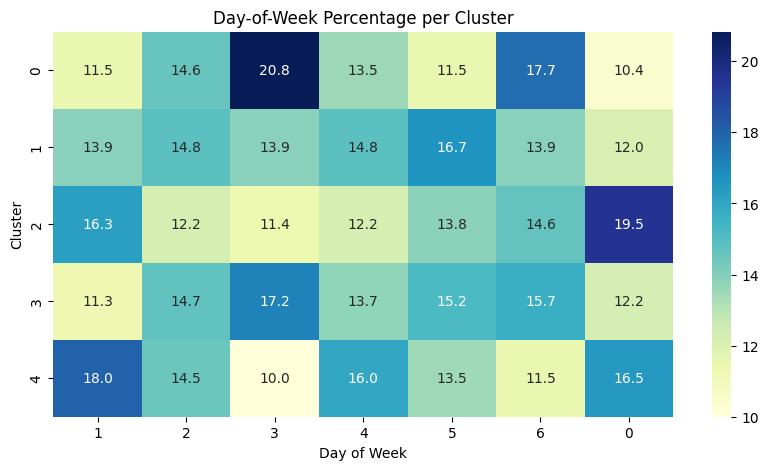

In [17]:
plt.figure(figsize=(10,5))
sns.heatmap(day_of_week_table.set_index('cluster')[['1','2','3','4','5','6','0']],annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Day-of-Week Percentage per Cluster")
plt.ylabel("Cluster")
plt.xlabel("Day of Week")
plt.show()

### Considering Yearly data distribution percentage in cluster

In [18]:
year_cluster = (
    day_numeric.groupby(['cluster', 'yr'])
    .size()
    .reset_index(name='days_count')
)
total_days_cluster = day_numeric.groupby('cluster').size().reset_index(name='total_days')

year_cluster = year_cluster.merge(total_days_cluster, on='cluster')
year_cluster['percentage'] = (year_cluster['days_count'] / year_cluster['total_days'] * 100).round(2)

# Pivot table for easier view
year_pivot = year_cluster.pivot(index='cluster', columns='yr', values='percentage').fillna(0)
year_pivot.columns = ['2011', '2012']  # Rename for clarity
year_pivot['Total_Days'] = total_days_cluster.set_index('cluster')['total_days']

# Find most and least represented year per cluster
year_cluster_summary = []
for cluster_id, row in year_pivot.iterrows():
    most_year = row[['2011','2012']].idxmax()
    least_year = row[['2011','2012']].idxmin()
    year_cluster_summary.append({
        'cluster': cluster_id,
        '2011 (%)': row['2011'],
        '2012 (%)': row['2012'],
        'Total_Days': row['Total_Days'],
        'Most_Year': most_year,
        'Least_Year': least_year
    })

year_cluster_summary_df = pd.DataFrame(year_cluster_summary)
year_cluster_summary_df

,cluster,2011 (%),2012 (%),Total_Days,Most_Year,Least_Year
0,0,77.08,22.92,96.0,2011,2012
1,1,30.56,69.44,108.0,2012,2011
2,2,60.16,39.84,123.0,2011,2012
3,3,31.37,68.63,204.0,2012,2011
4,4,60.00,40.00,200.0,2011,2012


In [19]:
# Group by cluster and year, sum total bike counts
year_cnt_cluster = (
    day_numeric.groupby(['cluster', 'yr'])['cnt']
    .sum()
    .reset_index()
)
# Pivot for easier view
year_cnt_pivot = year_cnt_cluster.pivot(index='cluster', columns='yr', values='cnt').fillna(0)
year_cnt_pivot.columns = ['2011_Total_Count', '2012_Total_Count']  # Rename for clarity

# Add total count per cluster
year_cnt_pivot['Total_Count'] = year_cnt_pivot['2011_Total_Count'] + year_cnt_pivot['2012_Total_Count']
year_cnt_pivot

,2011_Total_Count,2012_Total_Count,Total_Count
cluster,,,
0,172140,54169,226309
1,136442,414384,550826
2,123761,149244,273005
3,304120,990045,1294165
4,506640,441734,948374


### Cluster_2011 & Cluster_2012
- Total bike counts per cluster for each year
- Line graph compare cluster patterns between 2011 and 2012
- Peaks in the lines show which clusters were busiest in each year

In [20]:
cluster_2011 = day_numeric[day_numeric['yr']==0].groupby('cluster')['cnt'].sum().reset_index()
cluster_2012 = day_numeric[day_numeric['yr']==1].groupby('cluster')['cnt'].sum().reset_index()

# Merge
cluster_merge = cluster_2011.merge(cluster_2012, on='cluster', suffixes=('_2011','_2012'))

# Convert cluster column to string for categorical x-axis
cluster_merge['cluster_str'] = cluster_merge['cluster'].astype(str)
source = ColumnDataSource(cluster_merge)

p = figure(
    title="Cluster-wise Total Bike Count: 2011 vs 2012",
    x_range=cluster_merge['cluster_str'].tolist(),
    x_axis_label='Cluster',
    y_axis_label='Total Bike Count',
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    width=800, height=500
)
p.line(x='cluster_str', y='cnt_2011', source=source, line_width=3, color='blue', legend_label='2011')
p.circle(x='cluster_str', y='cnt_2011', source=source, size=8, color='blue', alpha=0.8)
p.line(x='cluster_str', y='cnt_2012', source=source, line_width=3, color='orange', legend_label='2012')
p.circle(x='cluster_str', y='cnt_2012', source=source, size=8, color='orange', alpha=0.8)

hover = p.select_one(HoverTool)
hover.tooltips = [("Cluster", "@cluster_str"),("2011 Count", "@cnt_2011"),("2012 Count", "@cnt_2012")]
p.legend.location = "top_left"
p.legend.click_policy = "hide"
show(p)

# Bike-Sharing Data Clustering Analysis (Hour-Level)

In [91]:
hour = pd.read_csv("hour.csv")
hour_numeric = hour.select_dtypes(include='number')
hour_numeric = hour_numeric.drop(columns=['instant'])

In [92]:
hour_numeric.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [93]:
scaler = StandardScaler()
hour_scaled = scaler.fit_transform(hour_numeric)
pca = PCA(n_components=2)
hour_pca = pca.fit_transform(hour_scaled)
hour_numeric['PCA1'] = hour_pca[:,0]
hour_numeric['PCA2'] = hour_pca[:,1]
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.24827142 0.144815  ]


In [94]:
kmeans = KMeans(n_clusters=5, random_state=42)
hour_numeric['cluster'] = kmeans.fit_predict(hour_pca)
print(hour_numeric['cluster'].value_counts())


cluster
4    5187
0    4542
1    3398
2    2182
3    2070
Name: count, dtype: int64


In [95]:
source = ColumnDataSource(hour_numeric)
palette = Category10[10]

p = figure(
    title="Hourly Bike-Sharing Clusters (PCA Projection)",
    x_axis_label='PCA1',
    y_axis_label='PCA2',
    width=800, height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

for i in hour_numeric['cluster'].unique():
    cluster_data = hour_numeric[hour_numeric['cluster']==i]
    cluster_source = ColumnDataSource(cluster_data)
    p.scatter(
        'PCA1', 'PCA2', source=cluster_source,
        size=7, color=palette[i], alpha=0.6, legend_label=f"Cluster {i}"
    )

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
    ("Hour", "@hr"),
    ("Temp", "@temp"),
    ("Count", "@cnt")
]

p.legend.location = "top_right"
p.legend.title = "Clusters"

show(p)


In [96]:
# Hourly usage per cluster
hourly_pattern = hour_numeric.groupby(['cluster','hr'])['cnt'].mean().unstack()
hourly_pattern

hr,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cluster,,,,,,,,,,,,,,,,,,,,,
0,142.812500,109.200000,79.500000,NaN,NaN,36.000000,165.931034,380.232759,410.379167,276.909366,...,229.352740,242.337931,304.961864,362.732283,374.943750,315.684211,267.146429,226.635802,181.996599,133.155642
1,29.344186,19.852679,14.445946,7.67619,3.609302,12.073276,44.118943,79.701657,109.741935,114.926174,...,73.887500,74.461538,86.671429,119.500000,110.177419,90.444444,70.461538,60.040323,50.452555,36.251613
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504.714286,687.125984,352.000000,...,453.699346,437.229412,464.191837,630.262338,606.084084,486.598214,400.405405,347.774194,310.636364,NaN
3,78.333333,44.250000,18.250000,5.00000,NaN,32.000000,116.933333,297.927273,412.765306,248.077778,...,185.851064,191.244604,217.156028,272.350365,263.022388,219.153285,187.540146,158.120000,128.169355,87.000000
4,58.608511,38.684318,26.515400,13.49177,7.576763,23.585921,84.914097,125.444444,153.521739,174.802632,...,113.476190,118.288462,141.157895,159.172414,150.743590,145.948276,127.947917,113.096774,98.043210,71.004717


In [98]:
# Average count per hour (overall)
avg_hourly_usage = hour_numeric.groupby('hr')['cnt'].mean().reset_index()
avg_hourly_usage.columns = ['Hour', 'Avg_Count']

# Sort to identify peaks
avg_hourly_usage = avg_hourly_usage.sort_values('Avg_Count', ascending=False)
avg_hourly_usage.head(5)


,Hour,Avg_Count
17,17,461.452055
18,18,425.510989
8,8,359.011004
16,16,311.983562
19,19,311.523352


In [99]:
# Average hourly count per cluster
cluster_hourly = hour_numeric.groupby(['cluster', 'hr'])['cnt'].mean().reset_index()
cluster_hourly.columns = ['Cluster', 'Hour', 'Avg_Count']

# Find the hour with highest usage per cluster
peak_hours = cluster_hourly.loc[cluster_hourly.groupby('Cluster')['Avg_Count'].idxmax()].reset_index(drop=True)
peak_hours


,Cluster,Hour,Avg_Count
0,0,8,410.379167
1,1,17,119.500000
2,2,8,687.125984
3,3,8,412.765306
4,4,9,174.802632


In [100]:
source = ColumnDataSource(cluster_hourly)

p = figure(
    title="Cluster-wise Hourly Bike Usage Patterns",
    x_axis_label='Hour of Day',
    y_axis_label='Average Count',
    width=850, height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
palette = Category10[10]

for cluster_id in sorted(hour_numeric['cluster'].unique()):
    cluster_data = cluster_hourly[cluster_hourly['Cluster'] == cluster_id]
    p.line(
        x='Hour', y='Avg_Count', source=ColumnDataSource(cluster_data),
        color=palette[cluster_id], line_width=3, alpha=0.8, legend_label=f"Cluster {cluster_id}"
    )
    p.scatter(
        x='Hour', y='Avg_Count', source=ColumnDataSource(cluster_data),
        color=palette[cluster_id], size=6, alpha=0.7
    )

hover = p.select_one(HoverTool)
hover.tooltips = [("Cluster", "@Cluster"), ("Hour", "@Hour"), ("Avg Count", "@Avg_Count")]

p.legend.location = "top_left"
p.legend.title = "Clusters"

show(p)
from bokeh.models import ColumnDataSource, HoverTool, LabelSet

In [101]:
from bokeh.models import LabelSet

cluster_hourly = hour_numeric.groupby(['cluster', 'hr'])['cnt'].mean().reset_index()
cluster_hourly.columns = ['Cluster', 'Hour', 'Avg_Count']

peak_hours = cluster_hourly.loc[cluster_hourly.groupby('Cluster')['Avg_Count'].idxmax()].reset_index(drop=True)
peak_hours['Cluster_str'] = peak_hours['Cluster'].astype(str)

source = ColumnDataSource(cluster_hourly)
peak_source = ColumnDataSource(peak_hours)

p = figure(
    title="Peak Hour Identification per Cluster",
    x_axis_label="Hour of the Day",
    y_axis_label="Average Bike Count",
    width=850,
    height=450,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
colors = Category10[10]
for i, cluster in enumerate(cluster_hourly['Cluster'].unique()):
    cluster_data = cluster_hourly[cluster_hourly['Cluster'] == cluster]
    cluster_src = ColumnDataSource(cluster_data)
    
    p.line(
        x='Hour', y='Avg_Count',
        source=cluster_src,
        color=colors[i % len(colors)],
        line_width=2,
        legend_label=f"Cluster {cluster}"
    )
    p.scatter(
        x='Hour', y='Avg_Count',
        source=cluster_src,
        color=colors[i % len(colors)],
        size=6,
        alpha=0.8
    )
p.scatter(
    x='Hour', y='Avg_Count',
    source=peak_source,
    color='red', size=12, alpha=0.9, marker='star',
    legend_label='Peak Hour'
)
labels = LabelSet(
    x='Hour', y='Avg_Count', text='Cluster_str', level='glyph',
    x_offset=8, y_offset=8, source=peak_source,
    text_font_size='10pt', text_color='red'
)
p.add_layout(labels)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@Cluster_str"),
    ("Hour", "@Hour"),
    ("Avg Count", "@Avg_Count{0.0}")
]
p.legend.title = "Clusters"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
show(p)


### Insight discovery phase — not just clustering for patterns, but understanding why certain clusters (or hours/days) have higher usage.

## Feature Correlation & Impact

In [102]:
# Create a cleaned dataframe without PCA and cluster columns
hour_cleaned = hour.select_dtypes(include='number')
hour_cleaned = hour_cleaned.drop(columns=['instant'])
hour_cleaned.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


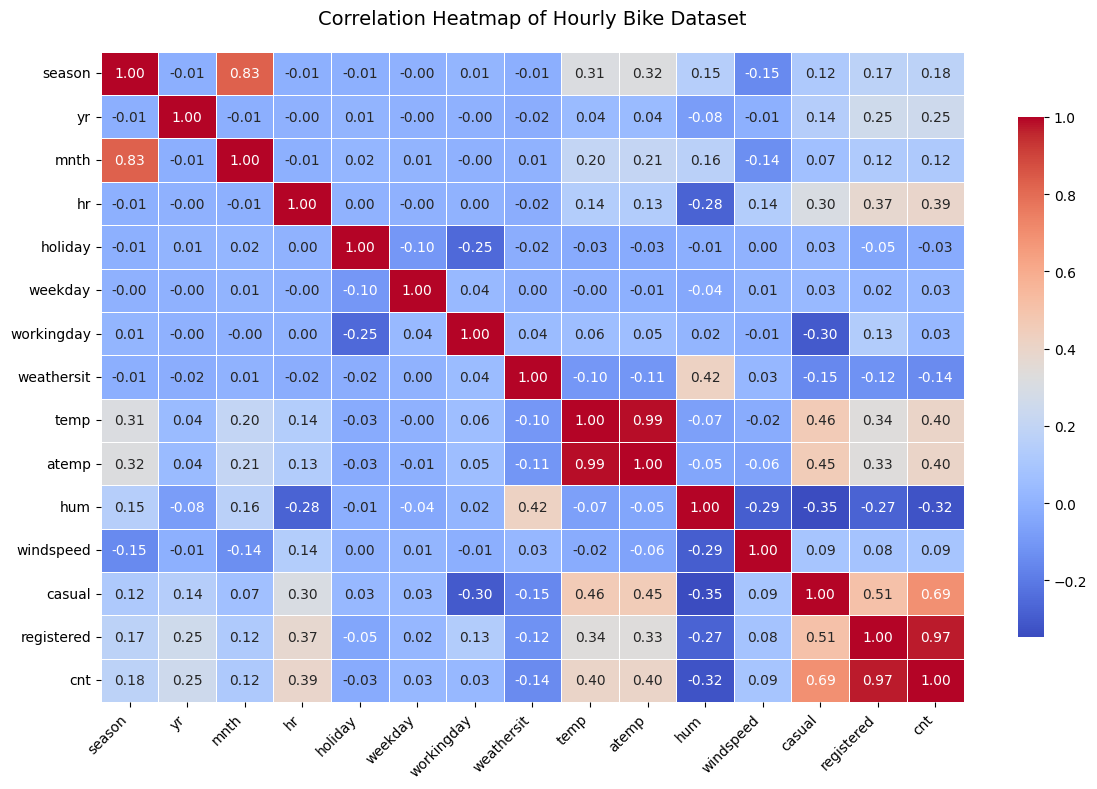

In [103]:
corr_matrix = hour_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Hourly Bike Dataset", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Analyze average bike count (cnt) for each hour of the day and see how it differs for working days and holidays.

In [104]:
hourly_usage = hour_cleaned.groupby(['hr', 'workingday'])['cnt'].mean().reset_index()
source = ColumnDataSource(hourly_usage)
p = figure(
    title="Average Bike Usage by Hour (Working Day vs Holiday/Weekend)",
    x_axis_label='Hour of Day',
    y_axis_label='Average Count',
    width=800,
    height=400,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)
colors = Category10[3]
for i, wd in enumerate(hourly_usage['workingday'].unique()):
    view = hourly_usage['workingday'] == wd
    p.line(
        x='hr', y='cnt', source=ColumnDataSource(hourly_usage[view]),
        color=colors[i], line_width=3, legend_label=f"Workingday={wd}"
    )
    p.scatter(
        x='hr', y='cnt', source=ColumnDataSource(hourly_usage[view]),
        color=colors[i], size=8, alpha=0.8
    )
hover = HoverTool(
    tooltips=[
        ("Hour", "@hr"),
        ("Workingday", "@workingday"),
        ("Avg Count", "@cnt{0.0}")
    ],
    mode='mouse'
)
p.add_tools(hover)
p.legend.location = "top_left"
p.legend.title = "Workingday Flag"
p.background_fill_color = "#f8f9fa"
p.title.text_font_size = "14pt"
show(p)

## Weather Impact (avg cnt per weathersit)

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy in + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [105]:
weather_usage = hour_cleaned.groupby('weathersit')['cnt'].mean().reset_index()
weather_usage['weathersit'] = weather_usage['weathersit'].astype(int).astype(str)
colors = Category10[4]
weather_usage['color'] = colors
source = ColumnDataSource(weather_usage)
p = figure(
    title="Average Bike Usage by Weather Condition",
    x_axis_label="Weather Situation (Avg. count per hour)",
    y_axis_label="Average Count",
    x_range=weather_usage['weathersit'].tolist(),
    width=600,
    height=400,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
p.vbar(
    x='weathersit',
    top='cnt',
    width=0.6,
    source=source,
    color='color',
    alpha=0.7
)
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("WeatherSit", "@weathersit"),
    ("Avg Count", "@cnt{0.0}")
]
show(p)

In [106]:
month_weather = hour_cleaned.groupby(['weathersit', 'mnth']).size().reset_index(name='count')
months_per_weather = month_weather.groupby('weathersit')['mnth'].apply(list).to_dict()
print(months_per_weather)

{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 4: [1]}


## AS above output show that weathersit 1 to 3 fall in all months but only 4 in 1(january). Lets see what is the average hour plot shows for weathersit across all months.

In [107]:
month_weather_avg = hour_cleaned.groupby(['weathersit', 'mnth'])['cnt'].mean().reset_index()

month_weather_avg['weathersit'] = month_weather_avg['weathersit'].astype(str)
source = ColumnDataSource(month_weather_avg)

colors = Category10[4]
weather_colors = {str(i+1): colors[i] for i in range(4)}

p = figure(
    title="Average Bike Count per Month by Weather Situation",
    x_axis_label="Month",
    y_axis_label="Average Count",
    width=800, height=400,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
for ws in month_weather_avg['weathersit'].unique():
    ws_data = month_weather_avg[month_weather_avg['weathersit'] == ws]
    ws_source = ColumnDataSource(ws_data)
    p.line(
        x='mnth',
        y='cnt',
        source=ws_source,
        line_width=3,
        color=weather_colors[ws],
        legend_label=f"Weathersit {ws}"
    )
    p.scatter(
        x='mnth',
        y='cnt',
        source=ws_source,
        size=8,
        color=weather_colors[ws],
        alpha=0.7
    )
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Month", "@mnth"),
    ("Weather", "@weathersit"),
    ("Avg Count", "@cnt{0.0}")
]
p.legend.title = "Weather Situation"
p.legend.location = "top_left"
show(p)

#### Despite weather being Clear; colder month do impact hourly usage as it drop drastically. It will be important to see the temp distribution across all month and the hourly usage.

In [108]:
from bokeh.transform import linear_cmap
from bokeh.palettes import RdBu

# Compute average count and median temperature
month_weather_median = hour_cleaned.groupby(['weathersit', 'mnth']).agg({
    'cnt': 'mean',       # still mean count
    'temp': 'median',   # median temperature for the month
    'atemp': 'median'
}).reset_index()

month_weather_median['weathersit'] = month_weather_median['weathersit'].astype(str)
source = ColumnDataSource(month_weather_median)

# Blue = cold, Red = hot
mapper = linear_cmap(field_name='temp', palette=RdBu[11], low=month_weather_median['temp'].min(), high=month_weather_median['temp'].max())

colors = Category10[4]
weather_colors = {str(i+1): colors[i] for i in range(4)}

p = figure(
    title="Average Bike Count per Month by Weather Situation and Temprature",
    x_axis_label="Month",
    y_axis_label="Average Count",
    width=800, height=400,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)
for ws in month_weather_median['weathersit'].unique():
    ws_data = month_weather_median[month_weather_median['weathersit'] == ws]
    ws_source = ColumnDataSource(ws_data)
    p.line(
        x='mnth',
        y='cnt',
        source=ws_source,
        line_width=3,
        color=weather_colors[ws],
        legend_label=f"Weathersit {ws}"
    )
    p.scatter(
        x='mnth',
        y='cnt',
        source=ws_source,
        size=8,
        color=mapper,
        alpha=0.7
    )
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Month", "@mnth"),
    ("Weather", "@weathersit"),
    ("Avg Count", "@cnt{0.0}"),
    ("Median Temp", "@temp{0.0}"),
    ("Median feel Temp", "@atemp{0.0}")
]

p.legend.title = "Weather Situation"
p.legend.location = "top_left"
show(p)

In [118]:
# Prepare data
features_to_show = hour_numeric.columns.drop(['PCA1', 'PCA2', 'cluster'])
source = ColumnDataSource(hour_numeric)

# Map cluster numbers to colors
palette = Category10[10]  # 10 distinct colors
colors = [palette[c] for c in hour_numeric['cluster']]
source.data['color'] = colors

# Create figure
p = figure(
    title="KMeans Clusters on PCA Components",
    x_axis_label='PCA1',
    y_axis_label='PCA2',
    width=800,
    height=600,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

# Scatter plot
p.scatter(
    x='PCA1',
    y='PCA2',
    source=source,
    color='color',  # now using the color column
    size=8,
    alpha=0.7
)

# Hover tool
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Cluster", "@cluster"),
] + [(f"{feat}", f"@{feat}") for feat in features_to_show]

show(p)


In [122]:
from bokeh.models import FactorRange
from bokeh.layouts import gridplot

clusters = sorted(hour_numeric['cluster'].unique())
plots = []

for cluster in clusters:
    cluster_data = hour_numeric[hour_numeric['cluster'] == cluster]
    counts = cluster_data[['registered','casual']].sum()
    
    factors = ['registered', 'casual']
    colors = [Category10[3][0], Category10[3][1]]  # one color per bar
    
    source = ColumnDataSource(data=dict(
        users=factors,
        counts=[counts['registered'], counts['casual']],
        color=colors
    ))
    
    p = figure(
        x_range=factors,
        y_range=(0, max(counts)+50),
        title=f"Cluster {cluster} - User Counts",
        width=400,
        height=400,
        tools="hover,save"
    )
    
    p.vbar(
        x='users',
        top='counts',
        width=0.6,
        source=source,
        color='color'   # reference column in source
    )
    
    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ("User Type", "@users"),
        ("Count", "@counts")
    ]
    
    plots.append(p)

grid = gridplot([plots[i:i+2] for i in range(0, len(plots), 2)])
show(grid)


In [127]:
clusters = sorted(hour_numeric['cluster'].unique())
plots = []

for cluster in clusters:
    cluster_data = hour_numeric[hour_numeric['cluster'] == cluster]
    
    # Aggregate hourly usage
    hourly_usage = cluster_data.groupby('hr')[['registered','casual']].mean().reset_index()
    
    source = ColumnDataSource(hourly_usage)
    
    p = figure(
        x_range=(0,23),
        y_range=(0, hourly_usage[['registered','casual']].values.max()+10),
        title=f"Cluster {cluster} - Hourly Usage",
        x_axis_label="Hour of Day",
        y_axis_label="Average Count",
        width=600,
        height=400,
        tools="pan,wheel_zoom,box_zoom,reset,hover,save"
    )
    
    # Registered line
    p.line(x='hr', y='registered', source=source, line_width=3, color=Category10[10][0], legend_label='Registered')
    p.scatter(x='hr', y='registered', source=source, size=6, color=Category10[10][0], alpha=0.7)
    
    # Casual line
    p.line(x='hr', y='casual', source=source, line_width=3, color=Category10[10][1], legend_label='Casual')
    p.scatter(x='hr', y='casual', source=source, size=6, color=Category10[10][1], alpha=0.7)
    
    # Hover tool
    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ("Hour", "@hr"),
        ("Registered", "@registered{0.0}"),
        ("Casual", "@casual{0.0}")
    ]
    
    p.legend.location = "top_left"
    plots.append(p)

# Layout: 2 plots per row
grid = gridplot([plots[i:i+2] for i in range(0, len(plots), 2)])
show(grid)


In [131]:
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.palettes import Blues4, Reds4

clusters = sorted(hour_numeric['cluster'].unique())
plots = []

for cluster in clusters:
    cluster_data = hour_numeric[hour_numeric['cluster'] == cluster]
    
    p = figure(
        x_range=(0,23),
        y_range=(0, cluster_data[['registered','casual']].values.max()+10),
        title=f"Cluster {cluster} - Hourly Usage",
        x_axis_label="Hour of Day",
        y_axis_label="Average Count",
        width=700,
        height=400,
        tools="pan,wheel_zoom,box_zoom,reset,hover,save"
    )
    
    # Compute hourly averages for each combination of workingday and user type
    for day_type, day_label in [(1, 'Working Day'), (0, 'Holiday')]:
        day_data = cluster_data[cluster_data['workingday'] == day_type]
        if day_data.empty:
            continue
        
        hourly_avg = day_data.groupby('hr')[['registered','casual']].mean().reset_index()
        source = ColumnDataSource(hourly_avg)
        
        # Lines with different shades
        p.line(x='hr', y='registered', source=source,
               color=Blues4[2] if day_type==1 else Blues4[0], line_width=2,
               legend_label=f"Registered - {day_label}")
        p.line(x='hr', y='casual', source=source,
               color=Reds4[2] if day_type==1 else Reds4[0], line_width=2,
               legend_label=f"Casual - {day_label}")
        
        # Scatter for points
        p.scatter(x='hr', y='registered', source=source,
                  color=Blues4[2] if day_type==1 else Blues4[0], size=6, alpha=0.8)
        p.scatter(x='hr', y='casual', source=source,
                  color=Reds4[2] if day_type==1 else Reds4[0], size=6, alpha=0.8)
    
    # Hover tool
    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ("Hour", "@hr"),
        ("Registered", "@registered{0.0}"),
        ("Casual", "@casual{0.0}")
    ]
    
    p.legend.location = "top_left"
    p.legend.title = "User Type & Day"
    plots.append(p)

# Show all cluster plots stacked vertically
show(column(*plots))


In [132]:
# Group by cluster and workingday, compute average registered and casual counts
cluster_summary = hour_numeric.groupby(['cluster', 'workingday'])[['registered','casual']].mean().reset_index()

# Replace workingday 1/0 with labels
cluster_summary['workingday'] = cluster_summary['workingday'].map({1: 'Weekday', 0: 'Holiday'})

# Rename columns for clarity
cluster_summary = cluster_summary.rename(columns={
    'registered': 'Avg Registered',
    'casual': 'Avg Casual'
})

# Show the summary table
print(cluster_summary)


   cluster workingday  Avg Registered  Avg Casual
0        0    Holiday      178.006130   73.302977
1        0    Weekday      226.470588   39.532059
2        1    Holiday       36.484899    6.893456
3        1    Weekday       52.407072    4.356301
4        2    Holiday      291.891447  187.811404
5        2    Weekday      478.260630   77.283465
6        3    Holiday      136.958199   51.829582
7        3    Weekday      193.314917   25.205110
8        4    Holiday       51.865735   12.928919
9        4    Weekday       61.057328    6.952556


# Identify Peak Usage

In [138]:
# Make a copy of the hour_numeric with cluster and other features
data = hour_numeric.copy()

# Map day type
data['day_type'] = data['workingday'].map({1:'Weekday', 0:'Holiday'})

# Aggregate per cluster, day type, and hour
peak_usage_summary = data.groupby(['cluster', 'day_type', 'hr']).agg(
    cnt_avg=('cnt', 'mean'),
    registered_avg=('registered', 'mean'),
    casual_avg=('casual', 'mean'),
    temp_avg=('temp', 'mean'),
    atemp_avg=('atemp', 'mean'),
    hum_avg=('hum', 'mean'),
    windspeed_avg=('windspeed', 'mean'),
    weathersit_mode=('weathersit', lambda x: x.mode()[0] if not x.mode().empty else np.nan)
).reset_index()

# Optional: sort for readability
peak_usage_summary = peak_usage_summary.sort_values(['cluster', 'day_type', 'hr'])

# Display
print(peak_usage_summary)


     cluster day_type  hr     cnt_avg  registered_avg  casual_avg  temp_avg  \
0          0  Holiday   0  161.320000      126.960000   34.360000  0.688000   
1          0  Holiday   1  129.000000       98.750000   30.250000  0.670000   
2          0  Holiday   2   79.500000       63.500000   16.000000  0.730000   
3          0  Holiday   7  105.000000       90.250000   14.750000  0.702500   
4          0  Holiday   8  179.637931      143.913793   35.724138  0.631724   
..       ...      ...  ..         ...             ...         ...       ...   
205        4  Weekday  19  158.806452      149.290323    9.516129  0.434194   
206        4  Weekday  20  137.844828      128.413793    9.431034  0.430345   
207        4  Weekday  21  121.846154      111.692308   10.153846  0.424872   
208        4  Weekday  22  105.945455       95.536364   10.409091  0.430000   
209        4  Weekday  23   72.682432       63.527027    9.155405  0.455000   

     atemp_avg   hum_avg  windspeed_avg  weathersit